In [1]:
# utilities
import pandas as pd
import jsonlines
import json
import pickle
import numpy as np
import ast
from csv import DictReader

# model training
#for binary classification
from sklearn.neighbors import KNeighborsClassifier 
from sklearn import svm
from sklearn.linear_model import LogisticRegression
#for hyperparams tuning
from sklearn.model_selection import RandomizedSearchCV
#for the confusion matrix
from sklearn import metrics

#visualization 
import seaborn as sns
import matplotlib.pyplot as plt

Firstly convert the jsonl files into dataframe and save it into .csv file

In [2]:
# DEV SET OK
# df = pd.read_json(r'emb_dev.jsonl')
# export_csv = df.to_csv(r'emb_dev.csv', index = None, header=True)

In [3]:
# TEST SET OK
# df1 = pd.read_json(r'emb_test.jsonl')
# export_csv = df1.to_csv(r'emb_test.csv', index = None, header=True)

In [4]:
# TRAIN SET OK
# df2 = pd.read_json(r'emb_train.jsonl',lines=True)
# export_csv = df2.to_csv(r'emb_train.csv', index = None, header=True)

In [5]:
# EXPORTING THE .CSV OF THE TRAIN SET
# from google.colab import files
# files.download("emb_train.csv")

**LOAD THE DATA**

In [2]:
#load the data
dev_df = pd.read_csv('emb_dev.csv')#,nrows=100)

In [3]:
dev_df.head()

,id,input,output,claim_embedding
0,137334,Fox 2000 Pictures released the film Soul Food.,[{'answer': 'SUPPORTS'}],"[-0.047759905457496005, -0.28736504912376404, ..."
1,111897,Telemundo is a English-language television net...,[{'answer': 'REFUTES'}],"[-0.058785255998373004, 0.024813191965222, -0...."
2,219028,Savages was exclusively a German film.,[{'answer': 'REFUTES'}],"[-0.08186284452676701, -0.08729772269725801, -..."
3,204361,The Cretaceous ended.,[{'answer': 'SUPPORTS'}],"[-0.049845222383737, 0.14868243038654302, -0.3..."
4,105095,Nicholas Brody is a character on Homeland.,[{'answer': 'SUPPORTS'}],"[-0.034806963056325003, 0.42876964807510304, -..."


In [3]:
train_df = pd.read_csv('emb_train.csv')#,nrows=100)

In [5]:
train_df.head()

,id,input,output,claim_embedding
0,75397,Nikolaj Coster-Waldau worked with the Fox Broa...,[{'answer': 'SUPPORTS'}],"[-0.248694404959678, 0.168318793177604, -0.085..."
1,150448,Roman Atwood is a content creator.,[{'answer': 'SUPPORTS'}],"[-0.16585971415042802, 0.14897175133228302, -0..."
2,214861,"History of art includes architecture, dance, s...",[{'answer': 'SUPPORTS'}],"[-0.228061705827713, -0.142438784241676, -0.22..."
3,156709,Adrienne Bailon is an accountant.,[{'answer': 'REFUTES'}],"[-0.12692221999168302, 0.319991946220397, 0.06..."
4,129629,Homeland is an American television spy thrille...,[{'answer': 'SUPPORTS'}],"[-0.352968782186508, 0.07248491048812801, 0.09..."


In [4]:
test_df = pd.read_csv('emb_test.csv')#,nrows=100)

In [5]:
''' Method to modify the dataset taking only the usefull fields 'output' and 'claim_embedding' and convert the output's values into binary values for the classification
  Input: dataframe to modify
  Output: modified dataframe
'''
def modify_df(df):  
    #delete the useless columns
    del df['id']
    del df['input']
    
    list_item=[]
    list_values=[]
    
    #extract the items from the output column
    series_output = pd.DataFrame(df['output'])
    for item in series_output['output']:
        #to convert the string of list into list of dict
        list_item=ast.literal_eval(item)
        # change values to represent labels as 0 ("REFUTES") and 1 ("SUPPORTS") and add them to a list
        for i in list_item:
            if (i['answer'] == 'REFUTES'):
                list_values.append(0)
            else:
                list_values.append(1)

    #create a new column of the df with the list of zeros and ones 
    df['labels'] = list_values
    #delete the output column
    del df['output']
    return df 

In [6]:
# obtain the dataset processed 
dev = modify_df(dev_df)

In [9]:
dev.head()

,claim_embedding,labels
0,"[-0.047759905457496005, -0.28736504912376404, ...",1
1,"[-0.058785255998373004, 0.024813191965222, -0....",0
2,"[-0.08186284452676701, -0.08729772269725801, -...",0
3,"[-0.049845222383737, 0.14868243038654302, -0.3...",1
4,"[-0.034806963056325003, 0.42876964807510304, -...",1


In [7]:
# obtain the dataset processed 
train = modify_df(train_df)

In [11]:
train.head()

,claim_embedding,labels
0,"[-0.248694404959678, 0.168318793177604, -0.085...",1
1,"[-0.16585971415042802, 0.14897175133228302, -0...",1
2,"[-0.228061705827713, -0.142438784241676, -0.22...",1
3,"[-0.12692221999168302, 0.319991946220397, 0.06...",0
4,"[-0.352968782186508, 0.07248491048812801, 0.09...",1


#### For training the classification model, firstly we split the datasets:
- train_set divided in:
    - x_train (embeddings vectors)  
    - y_train (label) 
- dev_set divided in:
    - x_dev (embeddings vectors), 
    - y_dev (label)
- test_set becames x_test (embeddings vectors)

In [8]:
x_train_emb = train['claim_embedding']
#convert string to list 
x_train = [n.strip('][').split(', ') for n in x_train_emb]

y_train = train.labels

In [9]:
y_train

0         1
1         1
2         1
3         0
4         1
         ..
104961    1
104962    0
104963    1
104964    1
104965    0
Name: labels, Length: 104966, dtype: int64

In [10]:
x_dev_emb = dev['claim_embedding']
#convert string to list 
x_dev = [n.strip('][').split(', ') for n in x_dev_emb]

y_dev = dev.labels

In [11]:
test_set = test_df.claim_embedding
#convert string to list 
x_test = [n.strip('][').split(', ') for n in test_set]

# KNN Classifier 
--------------------------------------------------------------------------------------

### Tuning on the dev set
Function for tuning the hyperparameters. It returns the best params to use for the KNN

In [18]:
''' Method for tuning the hyperparameters
  Input: splitted dev set into x and y for the fit of the RandomizedSearchCV
  Output: best params to use for the KNN
'''
def tuning(x_dev,y_dev):
    # define the parameter values that should be searched
    k_range = list(range(1,30,4))
    weight_options = ['uniform', 'distance'] # distance: more weight to more similar values
    algo_options = ['auto', 'ball_tree', 'kd_tree', 'brute']
    distance_options = [1,2,3] # different types of distances (manhattan, euclidean, minkowksi)
    
    # save the "parameter grid"
    param_grid = dict(n_neighbors=k_range, weights=weight_options, algorithm =algo_options,  p=distance_options)
    print('Params grid: ',param_grid) #need this for the report

    #define the classification model chosen
    model = KNeighborsClassifier()
    rand = RandomizedSearchCV(model, param_grid, cv=5, scoring='accuracy', n_iter=10, random_state=5, n_jobs=-1)
    rand.fit(x_dev, y_dev)
    rand.cv_results_
    
    # examine the best model
    print('Rand. Best Score: ', rand.best_score_)
    #save the optimize parameters
    best_param = rand.best_params_
    #return the tuning params for the model
    return best_param 

#### Now using the best parameter obtained by the tuning with the RandomizedSearchCV, we can train the train_set with the KNN

In [19]:
params = tuning(x_dev,y_dev) #dict of best parameters for the classifier

Params grid:  {'n_neighbors': [1, 5, 9, 13, 17, 21, 25, 29], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'p': [1, 2, 3]}


c:\users\stefania\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


Rand. Best Score:  0.5028724627633527


In [20]:
params

{'weights': 'uniform', 'p': 1, 'n_neighbors': 29, 'algorithm': 'kd_tree'}

TRAIN THE MODEL AND SAVE IT

In [21]:
''' Method for training the model using the KNeighborsClassifier() as binary classifier. After the training, the model is saved into a pickle file
  Input: dictionary of the tuned parameters, train set splitted in feature and target (x_train, y_train)
'''
def classifier(params, x_train, y_train):
    #train the model using the optimized params obtained in the tuning
    knn = KNeighborsClassifier(n_neighbors=params['n_neighbors'], weights=params['weights'], algorithm= params['algorithm'], p=params['p'])
    
    #fit the model
    knn.fit(x_train, y_train)
    
    # save the model to disk
    filename = 'KNN.sav'
    pickle.dump(knn, open(filename, 'wb'))

In [22]:
classifier(params, x_train, y_train)

c:\users\stefania\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


MAKE CLASS PREDICTION ON  THE SAVED MODEL 

In [12]:
# load the trained model from disk
knn = pickle.load(open('KNN.sav', 'rb'))

In [13]:
# make class predictions for the dev set, we need this to evaluate the model
y_pred_class = knn.predict(x_dev)

c:\users\stefania\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


EVALUATE THE MODEL

In [14]:
''' Function for the evaluation of the model. Using the metrics function from the library sklearn, here we compute the accuracy_score, the confusion_matrix and the precision and recall of the targets 'SUPPORTS', 'REFUTES'.
  Input: y_dev, predicted class
  Output: accuracy score,confusion matrix,precision score,recall score
'''
def evaluation(y_dev,y_pred_class):    
    # compute the accuracy 
    accuracy = metrics.accuracy_score(y_dev, y_pred_class)
    
    #build the confusion matrix and plot it
    confusion = metrics.confusion_matrix(y_dev, y_pred_class)
                #[row, column]
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    
    # visualize Confusion Matrix
    sns.heatmap(confusion,annot=True,fmt="d") 
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # compute the precision and the recall on the label and print them
    target_names = ['SUPPORTS', 'REFUTES']
    print(metrics.classification_report(y_dev, y_pred_class, target_names=target_names))
    
    return accuracy,confusion

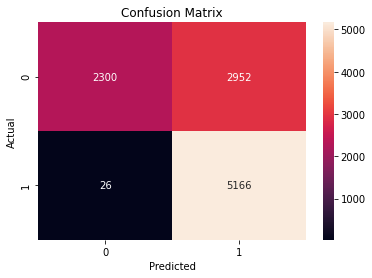

              precision    recall  f1-score   support

    SUPPORTS       0.99      0.44      0.61      5252
     REFUTES       0.64      0.99      0.78      5192

    accuracy                           0.71     10444
   macro avg       0.81      0.72      0.69     10444
weighted avg       0.81      0.71      0.69     10444



In [15]:
results = evaluation(y_dev,y_pred_class)

In [16]:
print('Accuracy value: ',results[0])
conf_matrix = results[1]

Accuracy value:  0.7148602068173113


In [17]:
conf_matrix

array([[2300, 2952],
       [  26, 5166]], dtype=int64)

In [18]:
print('F1 value: ', metrics.f1_score(y_dev, y_pred_class))

F1 value:  0.7762584522915102


**For the chosen classifier, get predictions for the official test set associated to the best hyperparameter configuration.**

In [19]:
test_df = pd.read_csv('emb_test.csv')#,nrows=100)

In [20]:
test_set = test_df.claim_embedding
#convert string to list 
x_test = [n.strip('][').split(', ') for n in test_set]

In [21]:
# load the trained model from disk
knn = pickle.load(open('KNN.sav', 'rb'))
# get predictions for the official test set 
pred_test = knn.predict(x_test)

c:\users\stefania\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


In [29]:
with open('emb_test.csv', 'r') as read_obj:
    # pass the file object to DictReader() to get the DictReader object
    dict_reader = DictReader(read_obj)
    # get a list of dictionaries from dict_reader
    json_test = list(dict_reader)

    #delete the useless fields    
for i in range(len(json_test)):
    del json_test[i]['claim_embedding'], json_test[i]['input']

In [30]:
for index in range(len(json_test)): 
    if pred_test[index]==1:
        json_test[index]['output']= [{'answer':"SUPPORT"}]
    else:
        json_test[index]['output']= [{'answer':"REFUTES"}]

In [31]:
json_test

[{'id': '161592', 'output': [{'answer': 'SUPPORT'}]},
 {'id': '65795', 'output': [{'answer': 'SUPPORT'}]},
 {'id': '34704', 'output': [{'answer': 'REFUTES'}]},
 {'id': '179775', 'output': [{'answer': 'SUPPORT'}]},
 {'id': '82854', 'output': [{'answer': 'REFUTES'}]},
 {'id': '169240', 'output': [{'answer': 'SUPPORT'}]},
 {'id': '164387', 'output': [{'answer': 'SUPPORT'}]},
 {'id': '91295', 'output': [{'answer': 'SUPPORT'}]},
 {'id': '84803', 'output': [{'answer': 'SUPPORT'}]},
 {'id': '6549', 'output': [{'answer': 'SUPPORT'}]},
 {'id': '32930', 'output': [{'answer': 'SUPPORT'}]},
 {'id': '143761', 'output': [{'answer': 'SUPPORT'}]},
 {'id': '47344', 'output': [{'answer': 'SUPPORT'}]},
 {'id': '110338', 'output': [{'answer': 'REFUTES'}]},
 {'id': '216604', 'output': [{'answer': 'SUPPORT'}]},
 {'id': '117692', 'output': [{'answer': 'SUPPORT'}]},
 {'id': '159310', 'output': [{'answer': 'SUPPORT'}]},
 {'id': '16412', 'output': [{'answer': 'SUPPORT'}]},
 {'id': '24582', 'output': [{'answer':

**Put the predictions in a file named “test_set_pred_1.jsonl”**

In [33]:
# save the prediction into a file
with jsonlines.open('test_set_pred_1.jsonl', mode = 'w') as writer:
    writer.write(json_test)

-----------------------------------------------------------------------------------------

# LogisticRegression Classifier
--------------------------------------------------------------------------------------

### Tuning on the dev set
Function for tuning the hyperparameters. It returns the best params to use for the LR

In [16]:
''' Method for tuning the hyperparameters
  Input: splitted dev set into x and y for the fit of the RandomizedSearchCV
  Output: best params to use for the KNN
'''
def tuning(x_dev,y_dev):
    # define the parameter values that should be searched
    penalty=['l1', 'l2', 'elasticnet', 'none']
    dual=[True,False]
    C_range=list(np.arange(1,5,0.5))
    solver=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    multi_class=['auto', 'ovr', 'multinomial']

    # save the "parameter grid"
    param_grid = dict(penalty=penalty,dual=dual,C=C_range,solver=solver,\
                     multi_class=multi_class)
    print('Params grid: ',param_grid) #need this for the report

    #define the classification model chosen
    model = LogisticRegression()
    rand = RandomizedSearchCV(model, param_grid, cv=5, scoring='accuracy', n_iter=10, random_state=5, n_jobs=-1)
    rand.fit(x_dev, y_dev)
    rand.cv_results_
    
    # examine the best model
    print('Rand. Best Score: ', rand.best_score_)
    #save the optimize parameters
    best_param = rand.best_params_
    #return the tuning params for the model
    return best_param 

#### Now using the best parameter obtained by the tuning with the RandomizedSearchCV, we can train the train_set with the LR

In [17]:
params = tuning(x_dev,y_dev) #dict of best parameters for the classifier

Params grid:  {'penalty': ['l1', 'l2', 'elasticnet', 'none'], 'dual': [True, False], 'C': [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'multi_class': ['auto', 'ovr', 'multinomial']}


c:\users\stefania\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.99444623        nan        nan 0.99597802 0.99655273        nan
        nan 0.99664847        nan        nan]
  warnings.warn(


Rand. Best Score:  0.9966484724767024


In [18]:
params

{'solver': 'liblinear',
 'penalty': 'l2',
 'multi_class': 'ovr',
 'dual': False,
 'C': 4.0}

TRAIN THE MODEL AND SAVE IT

In [19]:
''' Method for training the model using the LogisticRegression() as binary classifier. After the training, the model is saved into a pickle file
  Input: dictionary of the tuned parameters, train set splitted in feature and target (x_train, y_train)
'''
def classifier(params, x_train, y_train):
    #train the model using the optimized params obtained in the tuning
    lr = LogisticRegression(solver=params['solver'],penalty=params['penalty'],C=params['C'],\
    multi_class=params['multi_class'],dual=params['dual'])
    
    #fit the model
    lr.fit(x_train, y_train)
    
    # save the model to disk
    filename = 'LR.sav'
    pickle.dump(lr, open(filename, 'wb'))

In [39]:
classifier(params, x_train, y_train)

MAKE CLASS PREDICTION ON  THE SAVED MODEL 

In [40]:
# load the trained model from disk
lr = pickle.load(open('LR.sav', 'rb'))

In [41]:
# make class predictions for the dev set, we need this to evaluate the model
y_pred_class_lr = lr.predict(x_dev)

c:\users\stefania\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


EVALUATE THE MODEL

In [42]:
''' Function for the evaluation of the model. Using the metrics function from the library sklearn, here we compute the accuracy_score, the confusion_matrix and the precision and recall of the targets 'SUPPORTS', 'REFUTES'.
  Input: y_dev, predicted class
  Output: accuracy score,confusion matrix,precision score,recall score
'''
def evaluation(y_dev,y_pred_class):    
    # compute the accuracy 
    accuracy = metrics.accuracy_score(y_dev, y_pred_class)
    
    #build the confusion matrix and plot it
    confusion = metrics.confusion_matrix(y_dev, y_pred_class)
                #[row, column]
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    
    # visualize Confusion Matrix
    sns.heatmap(confusion,annot=True,fmt="d") 
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # compute the precision and the recall on the label and print them
    target_names = ['SUPPORTS', 'REFUTES']
    print(metrics.classification_report(y_dev, y_pred_class, target_names=target_names))
    
    return accuracy,confusion

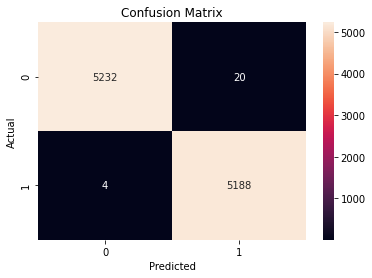

              precision    recall  f1-score   support

    SUPPORTS       1.00      1.00      1.00      5252
     REFUTES       1.00      1.00      1.00      5192

    accuracy                           1.00     10444
   macro avg       1.00      1.00      1.00     10444
weighted avg       1.00      1.00      1.00     10444



In [43]:
results = evaluation(y_dev,y_pred_class_lr)

In [44]:
print('Accuracy value: ',results[0])
conf_matrix = results[1]

Accuracy value:  0.9977020298736117


In [45]:
conf_matrix

array([[5232,   20],
       [   4, 5188]], dtype=int64)

In [46]:
print('F1 value: ', metrics.f1_score(y_dev, y_pred_class_lr))

F1 value:  0.9976923076923078


**For the chosen classifier, get predictions for the official test set associated to the best hyperparameter configuration.**

In [47]:
test_df = pd.read_csv('emb_test.csv')#,nrows=100)

In [48]:
test_set = test_df.claim_embedding
#convert string to list 
x_test = [n.strip('][').split(', ') for n in test_set]

In [51]:
# load the trained model from disk
lr = pickle.load(open('LR.sav', 'rb'))
# get predictions for the official test set 
pred_test = lr.predict(x_test)

c:\users\stefania\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


In [52]:
with open('emb_test.csv', 'r') as read_obj:
    # pass the file object to DictReader() to get the DictReader object
    dict_reader = DictReader(read_obj)
    # get a list of dictionaries from dict_reader
    json_test = list(dict_reader)

    #delete the useless fields    
for i in range(len(json_test)):
    del json_test[i]['claim_embedding'], json_test[i]['input']

In [55]:
for index in range(len(json_test)):
    for i in range(len(pred_test)): 
        if pred_test[i]==1:
            json_test[index]['answer']= {'label':'SUPPORT'}
        else:
            json_test[index]['answer']= {'label':'REFUTES'}

In [56]:
json_test

[{'id': '161592', 'answer': {'label': 'REFUTES'}},
 {'id': '65795', 'answer': {'label': 'REFUTES'}},
 {'id': '34704', 'answer': {'label': 'REFUTES'}},
 {'id': '179775', 'answer': {'label': 'REFUTES'}},
 {'id': '82854', 'answer': {'label': 'REFUTES'}},
 {'id': '169240', 'answer': {'label': 'REFUTES'}},
 {'id': '164387', 'answer': {'label': 'REFUTES'}},
 {'id': '91295', 'answer': {'label': 'REFUTES'}},
 {'id': '84803', 'answer': {'label': 'REFUTES'}},
 {'id': '6549', 'answer': {'label': 'REFUTES'}},
 {'id': '32930', 'answer': {'label': 'REFUTES'}},
 {'id': '143761', 'answer': {'label': 'REFUTES'}},
 {'id': '47344', 'answer': {'label': 'REFUTES'}},
 {'id': '110338', 'answer': {'label': 'REFUTES'}},
 {'id': '216604', 'answer': {'label': 'REFUTES'}},
 {'id': '117692', 'answer': {'label': 'REFUTES'}},
 {'id': '159310', 'answer': {'label': 'REFUTES'}},
 {'id': '16412', 'answer': {'label': 'REFUTES'}},
 {'id': '24582', 'answer': {'label': 'REFUTES'}},
 {'id': '14845', 'answer': {'label': 'REFU

**Put the predictions in a file named “test_set_pred_2.jsonl”**

In [33]:
# save the prediction into a file
with jsonlines.open('test_set_pred_2.jsonl', mode = 'w') as writer:
    writer.write(json_test)

In [34]:
dd = pd.read_json('test_set_pred_2.jsonl')

In [38]:
dd['answer']

0        {'label': 'REFUTES'}
1        {'label': 'REFUTES'}
2        {'label': 'REFUTES'}
3        {'label': 'REFUTES'}
4        {'label': 'REFUTES'}
                 ...         
10095    {'label': 'REFUTES'}
10096    {'label': 'REFUTES'}
10097    {'label': 'REFUTES'}
10098    {'label': 'REFUTES'}
10099    {'label': 'REFUTES'}
Name: answer, Length: 10100, dtype: object